<a href="https://colab.research.google.com/github/ccastano1997/Volatility-Based-Trading-Signal-Generation-using-LSTM-Networks/blob/main/Volatility_Based_Trading_Signal_Generation_using_LSTM_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance pandas numpy scikit-learn tensorflow pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=582c1b2b3661ea62b3495d763f9905fe4ab436c795351633117fa76d34e903b1
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [ ]:
pip install --upgrade pandas pandas_ta numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 77.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 2

In [ ]:
# Uninstall current versions to ensure a clean slate
!pip uninstall -y numpy pandas pandas_ta

# Install specific, Colab-friendly versions
!pip install numpy==1.26.4 pandas==2.2.2 pandas_ta

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: pandas_ta 0.3.14b0
Uninstalling pandas_ta-0.3.14b0:
  Successfully uninstalled pandas_ta-0.3.14b0
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached pandas_ta-0.3.14b0-py3-none-any.whl
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.

In [11]:
import yfinance as yf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

## =================================================================
## PART 1: DATA PREPARATION
## =================================================================

# Use an explicit end date to ensure the full range is downloaded
spy_df = yf.download('SPY', start='2010-01-01', end='2024-07-08')

# Flatten columns
spy_df.columns = spy_df.columns.get_level_values(0)

# Add technical indicators
spy_df.ta.rsi(append=True)
spy_df.ta.macd(append=True)
spy_df.ta.bbands(append=True)

# Add the target variable
spy_df['Target'] = (spy_df['Close'].shift(-1) > spy_df['Close']).astype(int)

# Remove all incomplete rows at once
spy_df.dropna(inplace=True)

# Scale the Features
features = spy_df.columns.drop('Target')
target = 'Target'
scaler = MinMaxScaler()
spy_df[features] = scaler.fit_transform(spy_df[features])

print("✅ Data preparation complete.")
print(f"New DataFrame shape: {spy_df.shape}")


## =================================================================
## PART 2: BUILD AND TRAIN THE LSTM MODEL
## =================================================================

sequence_length = 60
X = []
y = []

features_np = spy_df[features].to_numpy()
target_np = spy_df[target].to_numpy()

for i in range(len(spy_df) - sequence_length):
    X.append(features_np[i:i + sequence_length])
    y.append(target_np[i + sequence_length])

X = np.array(X)
y = np.array(y)

# Split into Training and Test Sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the Model
model = Sequential([
    Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(units=50)),
    Dropout(0.2),
    Dense(units=1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the Model
print("\nStarting model training... This will take a few minutes. 🚀")
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

print("\n✅ Model training complete.")

/tmp/ipython-input-11-4136306888.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy_df = yf.download('SPY', start='2010-01-01', end='2024-07-08')
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Data preparation complete.
New DataFrame shape: (3617, 15)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 60, 100)        │        26,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 86,501 (337.89 KB)

 Trainable params: 86,501 (337.89 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training... This will take a few minutes. 🚀
Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - accuracy: 0.5540 - loss: 0.6879 - val_accuracy: 0.5860 - val_loss: 0.6910
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.5097 - loss: 0.6940 - val_accuracy: 0.5860 - val_loss: 0.6789
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.5627 - loss: 0.6872 - val_accuracy: 0.5860 - val_loss: 0.6834
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.5420 - loss: 0.6910 - val_accuracy: 0.5860 - val_loss: 0.6797
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 98ms/step - accuracy: 0.5635 - loss: 0.6841 - val_accuracy: 0.5860 - val_loss: 0.6797
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.5542 - loss: 0.6877 - val_accuracy: 0.5860 - val_loss: 0.6782
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 89ms/step - accuracy: 0.5591 - loss: 0.6864 - val_accuracy: 0.5860 - val_loss: 0.6813
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 85m

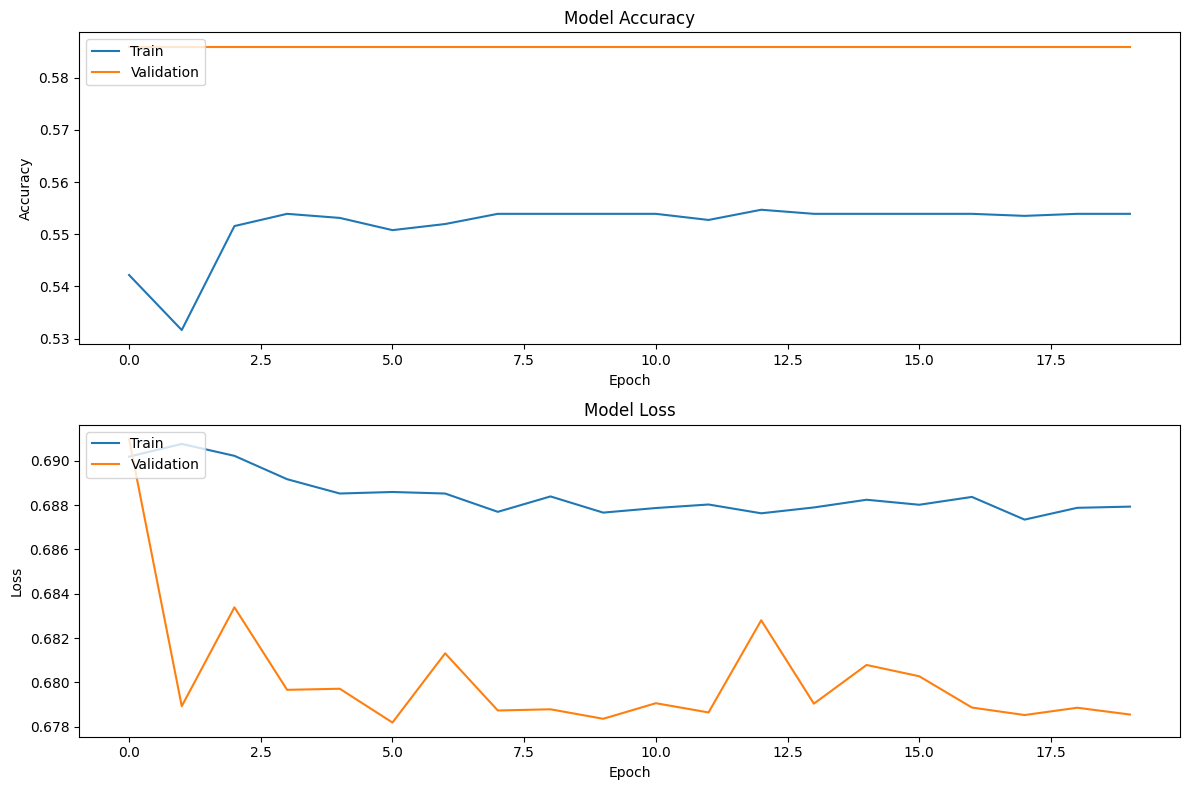

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step


/tmp/ipython-input-12-537889165.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_test_data['Prediction'] = (predictions > 0.5).astype(int)
/tmp/ipython-input-12-537889165.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_test_data['Market_Return'] = original_test_data['Close'].pct_change()
/tmp/ipython-input-12-537889165.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

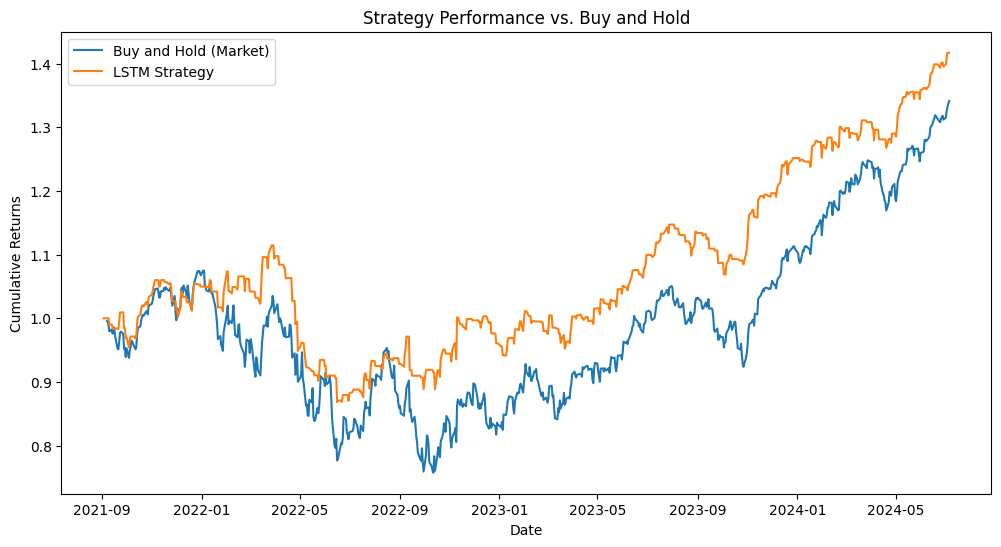

In [12]:
import matplotlib.pyplot as plt

# --- 1. Visualize Training History ---
# This helps us see if the model was learning over time.

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


# --- 2. Backtest on the Test Set (Most Important) ---
# This simulates how the model would have performed on unseen data.

# Getting the original 'Close' prices from the test period
original_test_data = spy_df.iloc[split + sequence_length:]

# Getting the model's predictions on the test set
predictions = model.predict(X_test)

# Adding the predictions and the actual 'Target' to the test data DataFrame
original_test_data['Prediction'] = (predictions > 0.5).astype(int)

# Calculating daily market returns
original_test_data['Market_Return'] = original_test_data['Close'].pct_change()

# Calculating strategy returns (we only get the market return if our prediction was correct)
original_test_data['Strategy_Return'] = np.where(original_test_data['Prediction'] == original_test_data['Target'], original_test_data['Market_Return'], 0)

# Calculating cumulative returns for both strategies
original_test_data['Cumulative_Market_Return'] = (1 + original_test_data['Market_Return']).cumprod()
original_test_data['Cumulative_Strategy_Return'] = (1 + original_test_data['Strategy_Return']).cumprod()

# Plotting the equity curve
plt.figure(figsize=(12, 6))
plt.plot(original_test_data['Cumulative_Market_Return'], label='Buy and Hold (Market)')
plt.plot(original_test_data['Cumulative_Strategy_Return'], label='LSTM Strategy')
plt.title('Strategy Performance vs. Buy and Hold')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.legend()
plt.show()